In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Define the custom confusion matrix plotting function
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if title:
        plt.title(title)

In [3]:
# # Function to calculate false positive rate and false negative rate from confusion matrix
def calculate_fp_fn_rates(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    return fpr, fnr

In [4]:
df = pd.read_csv("encoded_data.csv")
df.shape

(379, 20547)

In [5]:
df.head()

,Unnamed: 0,sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,...,pathologic_N,pathologic_T,patient_id,sample_type_id,OS,DSS,PFI,gender_MALE,tissue_prospective_collection_indicator_YES,vital_status_LIVING
0,0,TCGA-FP-A4BE-01,1.224808,-1.747726,-0.531035,-0.257772,0.019122,-0.37631,-0.627894,0.050754,...,0,6,A4BE,1,0,0.0,0,1.0,1.0,1.0
1,1,TCGA-BR-8081-01,0.614508,-0.110026,-0.531035,0.026728,-0.550378,-0.39861,-0.846094,1.182054,...,0,8,8081,1,0,0.0,0,0.0,1.0,1.0
2,3,TCGA-IN-7806-01,2.248808,4.360074,-0.531035,0.252328,-0.463778,-0.76811,-0.311694,0.710954,...,1,6,7806,1,0,0.0,0,1.0,1.0,1.0
3,5,TCGA-RD-A8N6-01,1.744208,6.345474,-0.531035,-0.058472,-0.000678,0.00489,0.246706,1.308254,...,2,3,A8N6,1,1,1.0,1,0.0,0.0,0.0
4,6,TCGA-D7-8575-01,-0.217192,2.179874,-0.037735,0.202628,-0.074578,0.59279,1.296006,-1.005546,...,2,6,8575,1,1,1.0,1,1.0,1.0,0.0


In [6]:
df = df.drop(['Unnamed: 0', 'sample', 'patient_id'], axis=1)

### Correlation matrix

comment out for now for runtime

In [7]:
# correlation_matrix = df.corr()[['DSS']]
# print(correlation_matrix)

In [8]:
# correlation_matrix

In [9]:
# # Reset the index to get a long-form DataFrame
# correlation_pairs = correlation_matrix.reset_index()
# correlation_pairs.columns = ['Feature', 'Correlation with DSS']

# # Add a numerical index for the features
# correlation_pairs['Feature Index'] = correlation_pairs.index

# # Create the scatter plot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=correlation_pairs, x='Feature Index', y='Correlation with DSS', size='Correlation with DSS', hue='Correlation with DSS', palette='coolwarm', legend=None)
# plt.title('Scatter Plot of Correlations with DSS')
# plt.xlabel('Feature Index')
# plt.ylabel('Correlation with DSS')
# plt.tight_layout()
# plt.show()

In [10]:
# high_correlation = correlation_matrix[correlation_matrix['DSS'] > 0.5]
# high_correlation

In [11]:
# low_correlation = correlation_matrix[correlation_matrix['DSS'] < -0.5]
# low_correlation

In [12]:
# flop = correlation_matrix.loc['PRTG']
# print("Chat, PRTG has a correlation to DSS of", flop)

### must drop these columns since they are also binary outcome variables about survival

In [13]:
cols_to_drop = [
    'OS',
    'PFI',
    'vital_status_LIVING'
]

In [14]:
df = df.drop(columns=cols_to_drop)

In [15]:
df['DSS'] = df['DSS'].astype(int)

In [16]:
df.head()

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,icd_o_3_site,neoplasm_histologic_grade,other_dx,pathologic_M,pathologic_N,pathologic_T,sample_type_id,DSS,gender_MALE,tissue_prospective_collection_indicator_YES
0,1.224808,-1.747726,-0.531035,-0.257772,0.019122,-0.37631,-0.627894,0.050754,-0.423399,2.842428,...,1,2,0,0,0,6,1,0,1.0,1.0
1,0.614508,-0.110026,-0.531035,0.026728,-0.550378,-0.39861,-0.846094,1.182054,0.615701,-0.477872,...,2,1,0,0,0,8,1,0,0.0,1.0
2,2.248808,4.360074,-0.531035,0.252328,-0.463778,-0.76811,-0.311694,0.710954,-0.423399,0.375328,...,0,2,0,0,1,6,1,0,1.0,1.0
3,1.744208,6.345474,-0.531035,-0.058472,-0.000678,0.00489,0.246706,1.308254,-0.423399,1.110628,...,3,2,0,0,2,3,1,1,0.0,0.0
4,-0.217192,2.179874,-0.037735,0.202628,-0.074578,0.59279,1.296006,-1.005546,2.770901,0.414428,...,1,2,0,0,2,6,1,1,1.0,1.0


In [17]:
df.iloc[:, -11:]

,icd_o_3_histology,icd_o_3_site,neoplasm_histologic_grade,other_dx,pathologic_M,pathologic_N,pathologic_T,sample_type_id,DSS,gender_MALE,tissue_prospective_collection_indicator_YES
0,0,1,2,0,0,0,6,1,0,1.0,1.0
1,0,2,1,0,0,0,8,1,0,0.0,1.0
2,2,0,2,0,0,1,6,1,0,1.0,1.0
3,1,3,2,0,0,2,3,1,1,0.0,0.0
4,3,1,2,0,0,2,6,1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
374,0,0,1,0,0,4,6,1,0,0.0,1.0
375,1,3,1,0,0,0,3,1,1,1.0,0.0
376,5,0,1,0,0,1,3,1,1,1.0,1.0
377,0,1,2,0,0,0,8,1,0,0.0,1.0


In [18]:
# Assuming df is your DataFrame
columns_to_drop = df.iloc[:, -11:].columns
columns_to_keep = ['DSS']

# Filter out 'DSS' from the columns to drop
columns_to_drop = [col for col in columns_to_drop if col not in columns_to_keep]

# Drop the columns
df = df.drop(columns=columns_to_drop)

In [19]:
df.head()

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,DSS
0,1.224808,-1.747726,-0.531035,-0.257772,0.019122,-0.37631,-0.627894,0.050754,-0.423399,2.842428,...,-1.587117,0.393267,-0.70569,-0.439777,-1.479386,0.645873,0.216105,-1.013033,-0.252312,0
1,0.614508,-0.110026,-0.531035,0.026728,-0.550378,-0.39861,-0.846094,1.182054,0.615701,-0.477872,...,0.588183,1.038367,-1.28139,-0.140877,-0.249686,1.188673,1.518105,2.037867,-0.196712,0
2,2.248808,4.360074,-0.531035,0.252328,-0.463778,-0.76811,-0.311694,0.710954,-0.423399,0.375328,...,-0.159517,-0.831733,1.79511,0.444823,-0.739786,-0.595127,0.730305,1.368767,-0.576912,0
3,1.744208,6.345474,-0.531035,-0.058472,-0.000678,0.00489,0.246706,1.308254,-0.423399,1.110628,...,-0.935417,-0.807333,1.84101,0.979423,1.017814,-0.529927,-0.513095,2.006967,3.034988,1
4,-0.217192,2.179874,-0.037735,0.202628,-0.074578,0.59279,1.296006,-1.005546,2.770901,0.414428,...,-1.587117,0.124467,1.46431,-0.060977,-0.750086,-1.555027,-0.944295,0.797967,0.196288,1


## SUCCESSFULLY droped all phenotype data

In [20]:
df.shape

(379, 20531)

In [21]:
# Get the counts of each class in the 'dss' column
dss_counts = df['DSS'].value_counts().reset_index()

# Rename the columns for clarity
dss_counts.columns = ['Class', 'Count']

# Display the DataFrame
dss_counts


,Class,Count
0,0,283
1,1,96


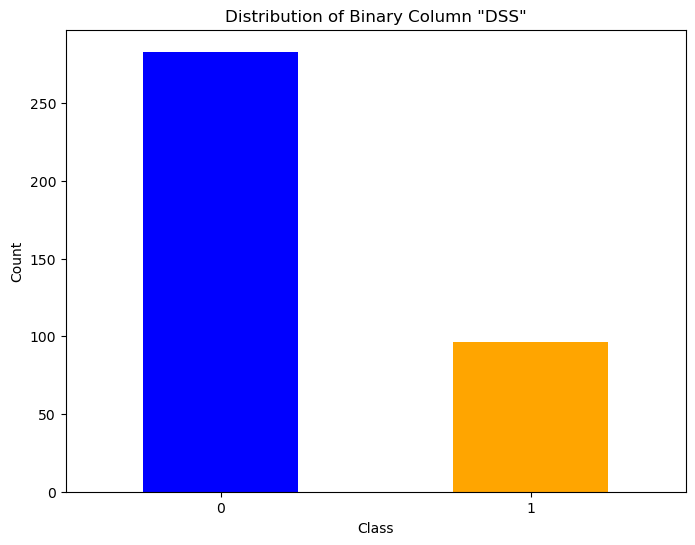

In [22]:
# Plot the distribution of the binary column 'dss'
plt.figure(figsize=(8, 6))
df['DSS'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Binary Column "DSS"')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [23]:
df.head()

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,DSS
0,1.224808,-1.747726,-0.531035,-0.257772,0.019122,-0.37631,-0.627894,0.050754,-0.423399,2.842428,...,-1.587117,0.393267,-0.70569,-0.439777,-1.479386,0.645873,0.216105,-1.013033,-0.252312,0
1,0.614508,-0.110026,-0.531035,0.026728,-0.550378,-0.39861,-0.846094,1.182054,0.615701,-0.477872,...,0.588183,1.038367,-1.28139,-0.140877,-0.249686,1.188673,1.518105,2.037867,-0.196712,0
2,2.248808,4.360074,-0.531035,0.252328,-0.463778,-0.76811,-0.311694,0.710954,-0.423399,0.375328,...,-0.159517,-0.831733,1.79511,0.444823,-0.739786,-0.595127,0.730305,1.368767,-0.576912,0
3,1.744208,6.345474,-0.531035,-0.058472,-0.000678,0.00489,0.246706,1.308254,-0.423399,1.110628,...,-0.935417,-0.807333,1.84101,0.979423,1.017814,-0.529927,-0.513095,2.006967,3.034988,1
4,-0.217192,2.179874,-0.037735,0.202628,-0.074578,0.59279,1.296006,-1.005546,2.770901,0.414428,...,-1.587117,0.124467,1.46431,-0.060977,-0.750086,-1.555027,-0.944295,0.797967,0.196288,1


In [24]:
X = df.drop(['DSS'], axis=1)
y = df['DSS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)


In [25]:
X['PRTG']

0     -1.848062
1     -0.264462
2     -1.018662
3      1.823238
4      0.472838
         ...   
374    1.665238
375    3.117638
376    1.096838
377   -1.559562
378    2.492838
Name: PRTG, Length: 379, dtype: float64

## Basic Logistic First

In [26]:
# Create a logistic regression model
basic_lr = LogisticRegression(max_iter=1000, random_state=8)

# Fit the model to the training data
basic_lr.fit(X_train, y_train)

lr_pred = basic_lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, lr_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7236842105263158


In [27]:

# # Display the evaluation results
# print(f"Accuracy: {accuracy}")
initial_coefficients = basic_lr.coef_
initial_coefficients

array([[ 0.00246921,  0.00237578, -0.00449806, ..., -0.00051165,
         0.02111295,  0.00258232]])

In [28]:
initial_coefficients = np.ravel(initial_coefficients)


In [29]:
initial_coefficients

array([ 0.00246921,  0.00237578, -0.00449806, ..., -0.00051165,
        0.02111295,  0.00258232])

In [30]:
len(initial_coefficients)

20530

## Lasso time

In [31]:
# Create a LassoCV model
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline

lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, random_state = 8, n_jobs=-1))

start_time = time.time()
lasso.fit(X_train, y_train)

# Print the chosen alpha
lasso_cv = lasso.named_steps['lassocv']
best_alpha = lasso_cv.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.08517600599465669


In [32]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=best_alpha))

# Initialize k-fold cross-validation
k = 5  # Number of folds for cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=8)

# Lists to store metrics and models for each fold
accuracy_scores = []
auc_scores = []
f1_scores = []
models = []

# Ensure y_train is a NumPy array
y_train = np.array(y_train)

start_time = time.time()
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the model
    lasso_pipeline.fit(X_train_fold, y_train_fold)

    # Predict on the validation set
    y_val_pred = lasso_pipeline.predict(X_val_fold)

    # Print some debug information
    print(f'Predictions for fold {len(models) + 1}: {y_val_pred[:10]}')
    print(f'Ground truth for fold {len(models) + 1}: {y_val_fold[:10]}')

    # Binarize predictions for classification metrics
    y_val_pred_binary = (y_val_pred > y_val_pred.mean()).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val_fold, y_val_pred_binary)
    auc = roc_auc_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred_binary)

    accuracy_scores.append(accuracy)
    auc_scores.append(auc)
    f1_scores.append(f1)

    # Save the model for this fold
    models.append(lasso_pipeline)

Predictions for fold 1: [0.20060242 0.22417694 0.1912316  0.24218112 0.19990284 0.2834787
 0.16743899 0.29076379 0.2701758  0.18945261]
Ground truth for fold 1: [1 1 0 1 0 1 0 0 0 0]
Predictions for fold 2: [0.242039   0.2537702  0.22100465 0.24403777 0.27955827 0.2932645
 0.21851226 0.28009725 0.18268321 0.34234186]
Ground truth for fold 2: [0 1 0 0 0 0 0 1 0 0]
Predictions for fold 3: [0.33472092 0.32946091 0.26840611 0.20055601 0.27183699 0.23541542
 0.25265126 0.21177931 0.24827006 0.19841267]
Ground truth for fold 3: [0 1 0 0 1 0 1 1 0 0]
Predictions for fold 4: [0.23644691 0.27351312 0.31596022 0.29959014 0.29096251 0.29344238
 0.27811108 0.32128655 0.20412356 0.24108011]
Ground truth for fold 4: [0 0 1 1 0 0 0 1 1 1]
Predictions for fold 5: [0.24580485 0.42912812 0.19593294 0.24141955 0.17973941 0.19472072
 0.25625246 0.36483267 0.2307179  0.21263618]
Ground truth for fold 5: [0 0 1 1 1 1 0 0 0 1]


In [33]:

# Print the metrics for each fold
print("\nMetrics for each fold:")
for i in range(k):
    print(f"Fold {i + 1}: Accuracy: {accuracy_scores[i] * 100:.2f}%, AUC: {auc_scores[i] * 100:.2f}%, F1 Score: {f1_scores[i] * 100:.2f}%")

# Calculate and print mean and standard deviation of the metrics
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f'\nMean Accuracy: {mean_accuracy * 100:.2f}% ± {std_accuracy * 100:.2f}%')
print(f'Mean AUC: {mean_auc * 100:.2f}% ± {std_auc * 100:.2f}%')
print(f'Mean F1 Score: {mean_f1 * 100:.2f}% ± {std_f1 * 100:.2f}%')

# Normalize the scores safely
def normalize(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    if max_score - min_score == 0:
        return np.zeros_like(scores)
    return (scores - min_score) / (max_score - min_score)

normalized_accuracy = normalize(accuracy_scores)
normalized_auc = normalize(auc_scores)
normalized_f1 = normalize(f1_scores)

# Combine the scores
combined_scores = normalized_accuracy + normalized_auc + normalized_f1
best_fold_index = np.argmax(combined_scores)  # Use combined score to determine the best fold
best_model = models[best_fold_index]

print(f'\nBest fold: {best_fold_index + 1} with Accuracy: {accuracy_scores[best_fold_index] * 100:.2f}%, AUC: {auc_scores[best_fold_index] * 100:.2f}%, F1 Score: {f1_scores[best_fold_index] * 100:.2f}%')

# Use the best model to make predictions
# Example prediction: best_model.predict(new_data)


Metrics for each fold:
Fold 1: Accuracy: 49.18%, AUC: 46.66%, F1 Score: 31.11%
Fold 2: Accuracy: 50.82%, AUC: 43.09%, F1 Score: 21.05%
Fold 3: Accuracy: 62.30%, AUC: 61.76%, F1 Score: 46.51%
Fold 4: Accuracy: 58.33%, AUC: 60.89%, F1 Score: 41.86%
Fold 5: Accuracy: 50.00%, AUC: 41.04%, F1 Score: 25.00%

Mean Accuracy: 54.13% ± 5.23%
Mean AUC: 50.69% ± 8.87%
Mean F1 Score: 33.11% ± 9.71%

Best fold: 3 with Accuracy: 62.30%, AUC: 61.76%, F1 Score: 46.51%


In [34]:
# Predict on test data and time
y_pred = lasso_pipeline.predict(X_test)
end_time = time.time()

### Understanding Thresholds in the `roc_curve` Function

The `roc_curve` function from `sklearn.metrics` evaluates the performance of a binary classifier by examining various thresholds. Here's how it determines and uses these thresholds:

1. **Predicted Probabilities (`y_pred`):**
   - These are the continuous output values from your classifier, representing the probability or confidence that a given instance belongs to the positive class.

2. **Unique Sorted Thresholds:**
   - The `roc_curve` function extracts all unique values from `y_pred` and sorts them in descending order. These unique values become the candidate thresholds.
   
3. **Threshold Evaluation:**
   - For each unique threshold, the function calculates the True Positive Rate (TPR) and False Positive Rate (FPR).
   - By iterating over the sorted unique values, the function evaluates the classifier's performance at each threshold.

AUC: 0.7049808429118773
Optimal threshold (Youden's J): 0.21727542962941815
Optimal threshold (Distance): 0.22687952758669305


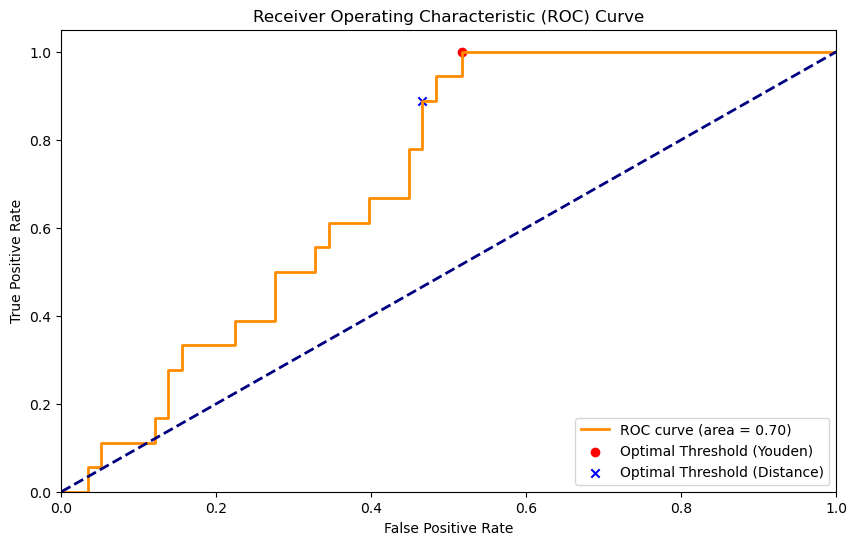

In [35]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Find the optimal threshold by maximizing Youden's J statistic
optimal_idx_youden = np.argmax(tpr - fpr)
optimal_threshold_youden = thresholds[optimal_idx_youden]
print("Optimal threshold (Youden's J):", optimal_threshold_youden)

# Find the optimal threshold by minimizing the distance to the top-left corner (0, 1)
optimal_idx_distance = np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))
optimal_threshold_distance = thresholds[optimal_idx_distance]
print("Optimal threshold (Distance):", optimal_threshold_distance)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot the optimal points
plt.scatter(fpr[optimal_idx_youden], tpr[optimal_idx_youden], marker='o', color='red', label='Optimal Threshold (Youden)')
plt.scatter(fpr[optimal_idx_distance], tpr[optimal_idx_distance], marker='x', color='blue', label='Optimal Threshold (Distance)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Assume y_true contains the true binary labels

# # Function to calculate performance metrics
# def evaluate_threshold(threshold, outputs, true_labels):
#     binary_outputs = (outputs >= threshold).astype(int)
#     accuracy = accuracy_score(true_labels, binary_outputs)
#     precision = precision_score(true_labels, binary_outputs, zero_division=1)
#     recall = recall_score(true_labels, binary_outputs, zero_division=1)
#     f1 = f1_score(true_labels, binary_outputs, zero_division=1)
#     return accuracy, precision, recall, f1

# # Evaluate different thresholds
# thresholds = np.arange(0.1, 1.0, 0.1)
# for threshold in thresholds:
#     accuracy, precision, recall, f1 = evaluate_threshold(threshold, y_pred, y_test)
#     print(f"Threshold: {threshold:.1f} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")


## 'optimal_threshold_youden' seems to be better overall with k-fold

In [37]:
# Set the threshold
threshold = optimal_threshold_youden

# Convert continuous outputs to binary
binary_outputs = (y_pred >= threshold).astype(int)

# print("Continuous outputs:", y_pred)
# print("Binary outputs:", binary_outputs)

In [38]:
estimation_time = end_time - start_time
print(estimation_time)

2.60748291015625


In [39]:
# Access the Lasso model within the pipeline and get its coefficients
lasso_model = lasso_pipeline.named_steps['lasso']
lasso_coefficients = lasso_model.coef_
lasso_coefficients

array([-0.,  0.,  0., ..., -0.,  0.,  0.])

In [40]:
len(lasso_coefficients)

20530

In [41]:
# Print list of new coefficients of all features
lasso_coefficients_df = pd.DataFrame({'Feature': X.columns, 'LassoCV_Coefficient': lasso_coefficients})
lasso_coefficients_df

,Feature,LassoCV_Coefficient
0,ARHGEF10L,-0.0
1,HIF3A,0.0
2,RNF17,0.0
3,RNF10,0.0
4,RNF11,0.0
...,...,...
20525,PTRF,0.0
20526,BCL6B,0.0
20527,GSTK1,-0.0
20528,SELP,0.0


In [42]:
# Check the shape of the arrays
print("Initial coefficients shape:", initial_coefficients.shape)
print("Lasso coefficients shape:", lasso_coefficients.shape)

Initial coefficients shape: (20530,)
Lasso coefficients shape: (20530,)


In [43]:
# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': np.arange(len(X.columns)),
    'Feature': X.columns,
    'Initial_Coefficients': initial_coefficients,
    'Lasso_Coefficients': lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Lasso_Coefficients'] == 0]['Feature_Index']

In [44]:
prtg_record = coefficients_df[coefficients_df['Feature'] == 'PRTG']
prtg_record

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
12222,12222,PRTG,0.023779,0.0


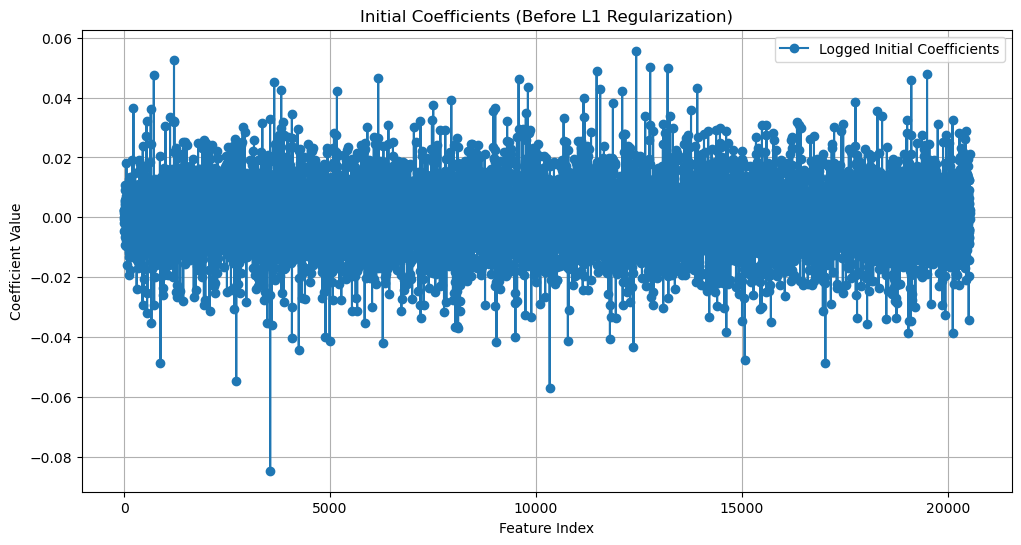

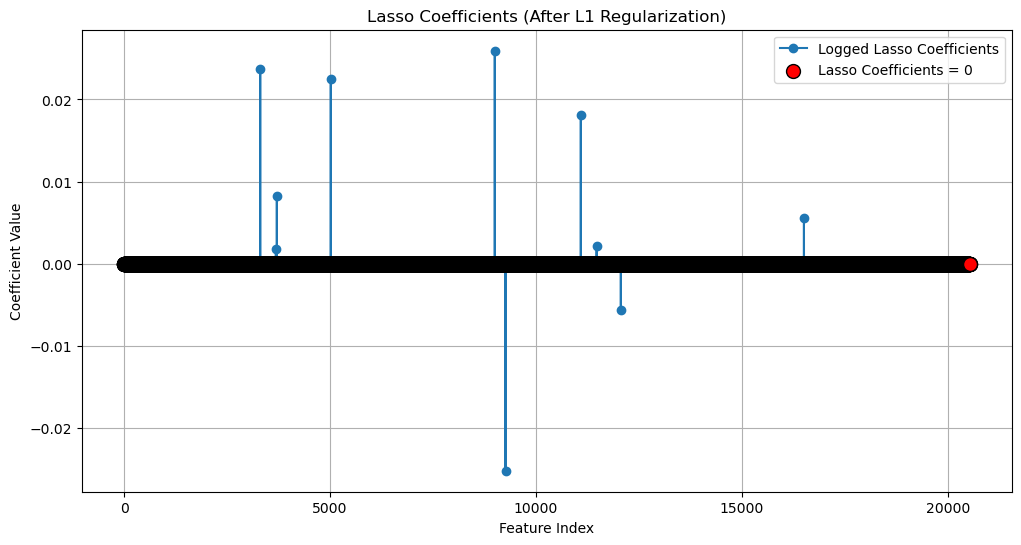

In [45]:
# Plot logged initial coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Initial_Coefficients'], marker='o', label='Logged Initial Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Initial Coefficients (Before L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

# Plot logged Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Filter the DataFrame to keep only the non-zero Lasso coefficients
non_zero_coefficients_df = coefficients_df[coefficients_df['Lasso_Coefficients'] != 0]

# Display the filtered DataFrame
non_zero_coefficients_df.shape

(11, 4)

In [50]:
# Sort the DataFrame by the 'Lasso_Coefficients' column in ascending order
non_zero_coefficients_df = non_zero_coefficients_df.sort_values(by='Lasso_Coefficients', ascending=True)
non_zero_coefficients_df = non_zero_coefficients_df.drop(columns='Feature_Index')
# Display the sorted DataFrame
non_zero_coefficients_df

,Feature,Initial_Coefficients,Lasso_Coefficients
9260,CHMP4C,-0.019645,-0.025213
12060,ZNF37A,-0.012063,-0.005622
14301,C2orf14,0.012412,0.000320
3683,DPPA5,0.023333,0.001813
11472,?|553137,0.048932,0.002147
16506,IQCF6,0.015942,0.005529
3707,HTR2C,0.025011,0.008284
11088,PCDHA13,0.024887,0.018093
5017,TAF6,0.013494,0.022501
3303,H2BFM,0.013616,0.023691


In [ ]:
import dataframe_image as dfi
dfi.export(non_zero_coefficients_df, 'top_genes.png')

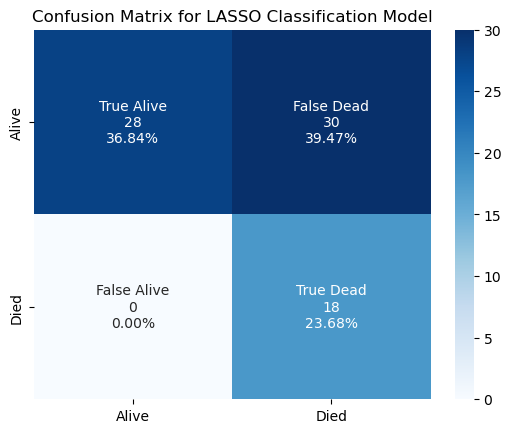

In [117]:
lasso_report = classification_report(y_test, binary_outputs, output_dict=True)

# Compute the confusion matrix
cf_matrix = confusion_matrix(y_test, binary_outputs)

# Define the category names
categories = ['Alive', 'Died']
labels = ['True Alive', 'False Dead', 'False Alive', 'True Dead']
# Plot the confusion matrix
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      title='Confusion Matrix for LASSO Classification Model')
plt.show()

In [118]:
binary_outputs

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1])

In [119]:
np.array(y_test)

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [126]:
lasso_metrics = []
# LassoCV model metrics
fpr, fnr = calculate_fp_fn_rates(cf_matrix)
lasso_metrics.append({
    'model': 'Lasso',
    'estimation_time_sec': round(end_time - start_time, 3),
    'accuracy': round(lasso_report['accuracy'], 3),
    'f1-score': round(lasso_report['weighted avg']['f1-score'], 3),
    'auc': round(roc_auc, 3),
    'false_positive_rate': round(fpr, 3),
    'false_negative_rate': round(fnr, 3)
})

lasso_metrics_df = pd.DataFrame(lasso_metrics)
lasso_metrics_df

,model,estimation_time_sec,accuracy,f1-score,auc,false_positive_rate,false_negative_rate
0,Lasso,3.186,0.605,0.626,0.705,0.517,0.0


### 0 fpr is good!!

In [128]:
# write to csv
lasso_metrics_df.to_csv('metrics.csv', index=False)